## Plan
1. Generate ground-truth signal x(t) = sin(2pi t) + 0.5 sin(6pi t), N=200.
2. Build Gaussian blur operator A (Toeplitz convolution), check singular values and condition number.
3. Create noisy measurements y = A x + n for low/medium/high sigma.
4. Baseline reconstruction with pseudoinverse (expected failure).
5. Diagnostics: singular values, Picard plot, L-curve.
6. Classical regularization sweeps: Tikhonov (lambda grid) and TSVD (k grid).
7. Summarize stats that an LLM can reason over; capture a placeholder recommendation.

In [1]:
import json
import math
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd, norm

In [2]:
# Experiment settings
N = 200
t = np.linspace(0.0, 1.0, N, endpoint=False)
noise_levels = {
    'low': 0.001,
    'medium': 0.01,
    'high': 0.05,
}
gaussian_sigma = 2.5  # blur width in samples
np.random.seed(7)

In [3]:
def build_ground_truth(t_grid):
    x = np.sin(2 * np.pi * t_grid) + 0.5 * np.sin(6 * np.pi * t_grid)
    return x

def gaussian_kernel(size, sigma):
    # Symmetric 1D Gaussian kernel
    idx = np.arange(-(size // 2), size // 2 + 1)
    kernel = np.exp(-0.5 * (idx / sigma) ** 2)
    kernel /= kernel.sum()
    return kernel

def blur_matrix(n, sigma, kernel_radius=10):
    # Build Toeplitz-like convolution matrix with circular padding
    ksize = 2 * kernel_radius + 1
    k = gaussian_kernel(ksize, sigma)
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            shift = (i - j) % n
            A[i, j] = k[shift] if shift < ksize else 0.0
    return A

def add_noise(y_clean, sigma):
    noise = np.random.normal(0.0, sigma, size=y_clean.shape)
    return y_clean + noise, noise

def mse(x_true, x_est):
    return float(np.mean((x_true - x_est) ** 2))

def psnr(x_true, x_est):
    mse_val = mse(x_true, x_est)
    if mse_val == 0:
        return math.inf
    max_val = np.max(np.abs(x_true))
    return 20 * math.log10(max_val) - 10 * math.log10(mse_val)

In [4]:
# Generate ground truth and blur operator
x_true = build_ground_truth(t)
A = blur_matrix(N, gaussian_sigma)
U, svals, Vt = svd(A, full_matrices=False)
condition_number = svals[0] / svals[-1]
print(f'Condition number: {condition_number:.2e}')

Condition number: 1.92e+07


In [5]:
# Measurements for all noise levels
y_clean = A @ x_true
y_dict = {}
noise_dict = {}
for level, sigma in noise_levels.items():
    y_noisy, noise = add_noise(y_clean, sigma)
    y_dict[level] = y_noisy
    noise_dict[level] = noise
y_dict.keys()

dict_keys(['low', 'medium', 'high'])

In [6]:
# Baseline pseudoinverse reconstructions
pinv_A = np.linalg.pinv(A)
baseline_results = {}
for level, y in y_dict.items():
    x_pinv = pinv_A @ y
    baseline_results[level] = {
        'x_hat': x_pinv,
        'mse': mse(x_true, x_pinv),
        'psnr': psnr(x_true, x_pinv),
        'rel_error': norm(x_true - x_pinv) / norm(x_true),
    }
baseline_results

{'low': {'x_hat': array([ 2369.80849447,    99.4253438 , -2552.12899069,  3703.49289481,
         -2931.51781906,   642.85432873,  1958.56607345, -3532.17752743,
          3318.81017005, -1475.12774428, -1042.92272507,  2995.7431579 ,
         -3443.21237104,  2207.36212078,    83.80399843, -2299.50934331,
          3385.44755149, -2825.38103836,   890.70711523,  1510.91275485,
         -3207.17860525,  3337.50039534, -1772.75267234,  -733.18464125,
          2915.53524237, -3624.05876688,  2482.49559248,   -74.43656341,
         -2344.177069  ,  3548.60201219, -2950.59718261,   902.84562524,
          1540.72173227, -3147.70681403,  3141.64467802, -1541.09583813,
          -840.33093521,  2822.95201507, -3423.00073967,  2354.98998472,
          -133.71670338, -2170.62166717,  3456.00423651, -3075.56474392,
          1171.16231236,  1365.44010759, -3266.30949529,  3533.73803848,
         -1978.41118605,  -615.56772168,  2898.34063704, -3676.33168741,
          2582.86477571,  -236.4051

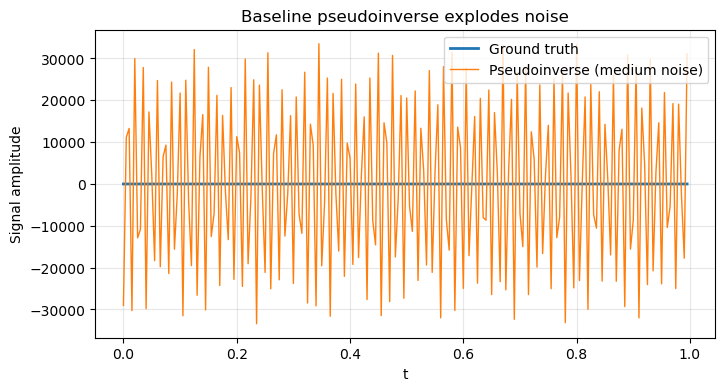

In [7]:
# Plot baseline failure for medium noise
medium = baseline_results['medium']['x_hat']
plt.figure(figsize=(8, 4))
plt.plot(t, x_true, label='Ground truth', linewidth=2)
plt.plot(t, medium, label='Pseudoinverse (medium noise)', linewidth=1)
plt.title('Baseline pseudoinverse explodes noise')
plt.xlabel('t')
plt.ylabel('Signal amplitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

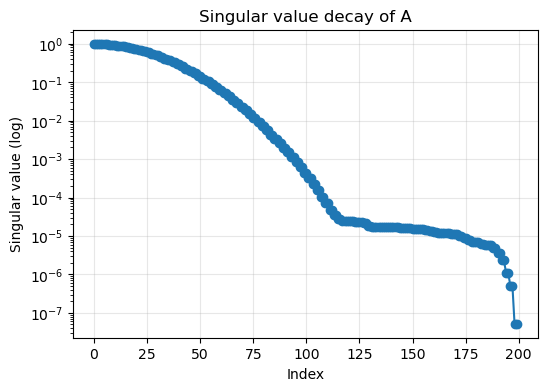

In [8]:
# Singular value decay (ill-posedness)
plt.figure(figsize=(6, 4))
plt.semilogy(svals, marker='o')
plt.title('Singular value decay of A')
plt.xlabel('Index')
plt.ylabel('Singular value (log)')
plt.grid(True, alpha=0.3)
plt.show()

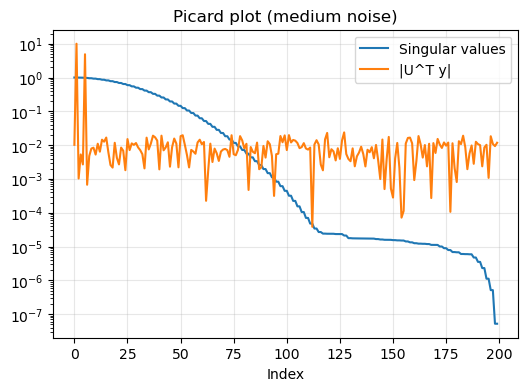

In [9]:
# Picard plot: singular values vs |U^T y|
level = 'medium'
uy = np.abs(U.T @ y_dict[level])
plt.figure(figsize=(6, 4))
plt.semilogy(svals, label='Singular values')
plt.semilogy(uy, label='|U^T y|')
plt.title('Picard plot (medium noise)')
plt.xlabel('Index')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

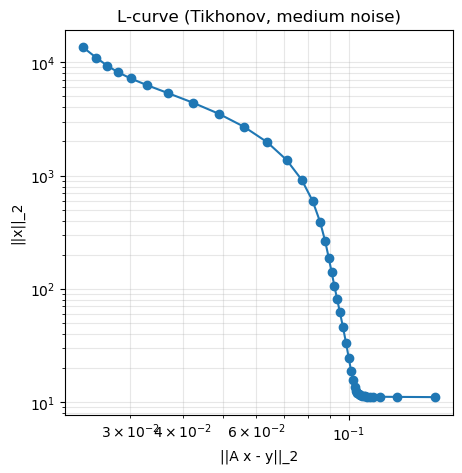

In [10]:
# L-curve for Tikhonov (L2)
lambdas = np.logspace(-6, -1, 40)
residual_norms = []
solution_norms = []
level = 'medium'
y = y_dict[level]
for lam in lambdas:
    filt = svals / (svals**2 + lam**2)
    x_tikh = (Vt.T * filt) @ (U.T @ y)
    residual_norms.append(norm(A @ x_tikh - y))
    solution_norms.append(norm(x_tikh))
plt.figure(figsize=(5, 5))
plt.loglog(residual_norms, solution_norms, marker='o')
plt.xlabel('||A x - y||_2')
plt.ylabel('||x||_2')
plt.title('L-curve (Tikhonov, medium noise)')
plt.grid(True, which='both', alpha=0.3)
plt.show()

In [11]:
# Regularization sweeps: Tikhonov and TSVD on medium noise
level = 'medium'
y = y_dict[level]
tikh_grid = np.logspace(-6, -1, 30)
tsvd_grid = np.arange(10, 120, 10)
tikh_results = []
for lam in tikh_grid:
    filt = svals / (svals**2 + lam**2)
    x_hat = (Vt.T * filt) @ (U.T @ y)
    tikh_results.append((lam, mse(x_true, x_hat), psnr(x_true, x_hat)))
tsvd_results = []
for k in tsvd_grid:
    filt = np.zeros_like(svals)
    filt[:k] = 1.0 / svals[:k]
    x_hat = (Vt.T * filt) @ (U.T @ y)
    tsvd_results.append((k, mse(x_true, x_hat), psnr(x_true, x_hat)))
tikh_best = min(tikh_results, key=lambda r: r[1])
tsvd_best = min(tsvd_results, key=lambda r: r[1])
print('Best Tikhonov (lambda, MSE, PSNR):', tikh_best)
print('Best TSVD (k, MSE, PSNR):', tsvd_best)

Best Tikhonov (lambda, MSE, PSNR): (0.1, 0.0004019786670461148, 34.59080274068727)
Best TSVD (k, MSE, PSNR): (10, 2.4091784687514855e-06, 56.81414306664618)


In [12]:
# LLM-guided reasoning placeholder: package diagnostics for prompting
diagnostics = {
    'condition_number': float(condition_number),
    'noise_level': level,
    'baseline': baseline_results['medium'],
    'tikhonov_grid': [{'lambda': float(l), 'mse': m, 'psnr': p} for l, m, p in tikh_results],
    'tsvd_grid': [{'k': int(k), 'mse': m, 'psnr': p} for k, m, p in tsvd_results],
    'suggestion_stub': 'Prefer Tikhonov with lambda near {:.2e}; TSVD k near {}'.format(tikh_best[0], tsvd_best[0]),
}
print(json.dumps({k: v if k != 'tikhonov_grid' and k != 'tsvd_grid' else '...grid omitted...' for k, v in diagnostics.items()}, indent=2))

TypeError: Object of type ndarray is not JSON serializable

## Notes and next steps
- Confirm the pseudoinverse failure visually and via error metrics.
- Use the diagnostics blob to craft an LLM prompt (e.g., feed condition number, Picard behavior, error sweeps).
- Add persistence later (save figures, JSON metrics under results/).
- When ready, expand to the other experiments (regularization comparison, LLM-guided selection, noise sensitivity).